## Analyse coefficients dynamiques CRE

Alexandre Castanié

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import sympy as sp
import xlsxwriter

In [2]:
from scipy import optimize

#### Données fournies par la CRE
https://www.cre.fr/Pages-annexes/open-data

In [3]:
#Récupération des données
CoeffsCRE=pd.read_excel("2eme semestre 2022.xlsx",sheet_name=-1,skiprows=2)
CoeffsCRE = CoeffsCRE.set_index('Horodate')
CoeffsCRE.index = pd.to_datetime(CoeffsCRE.index)

<ins> A quoi correspondent les données de la CRE ? </ins>

L'onglet "profils dynamiques" de l'excel de données de la CRE est composé des courbes de charge prévisionnelles à température normale et des gradients de température (=coefficients qui permettent de prendre en compte les variations de température). Ces grandeurs s'expriment au pas du règlement des écarts fixé à 30 min pour l'instant et s'étalent du 1er janvier 2022 au 31 décembre 2022.  
Pour chaque profil bleu, il est donné deux ensembles de paires de valeurs correspondants chacun à un lissage différent. Chaque ensemble est distingué par les appellations "1ère année de lissage" et "2ème année de lissage". A quoi correspondent exactement ces lissages ?

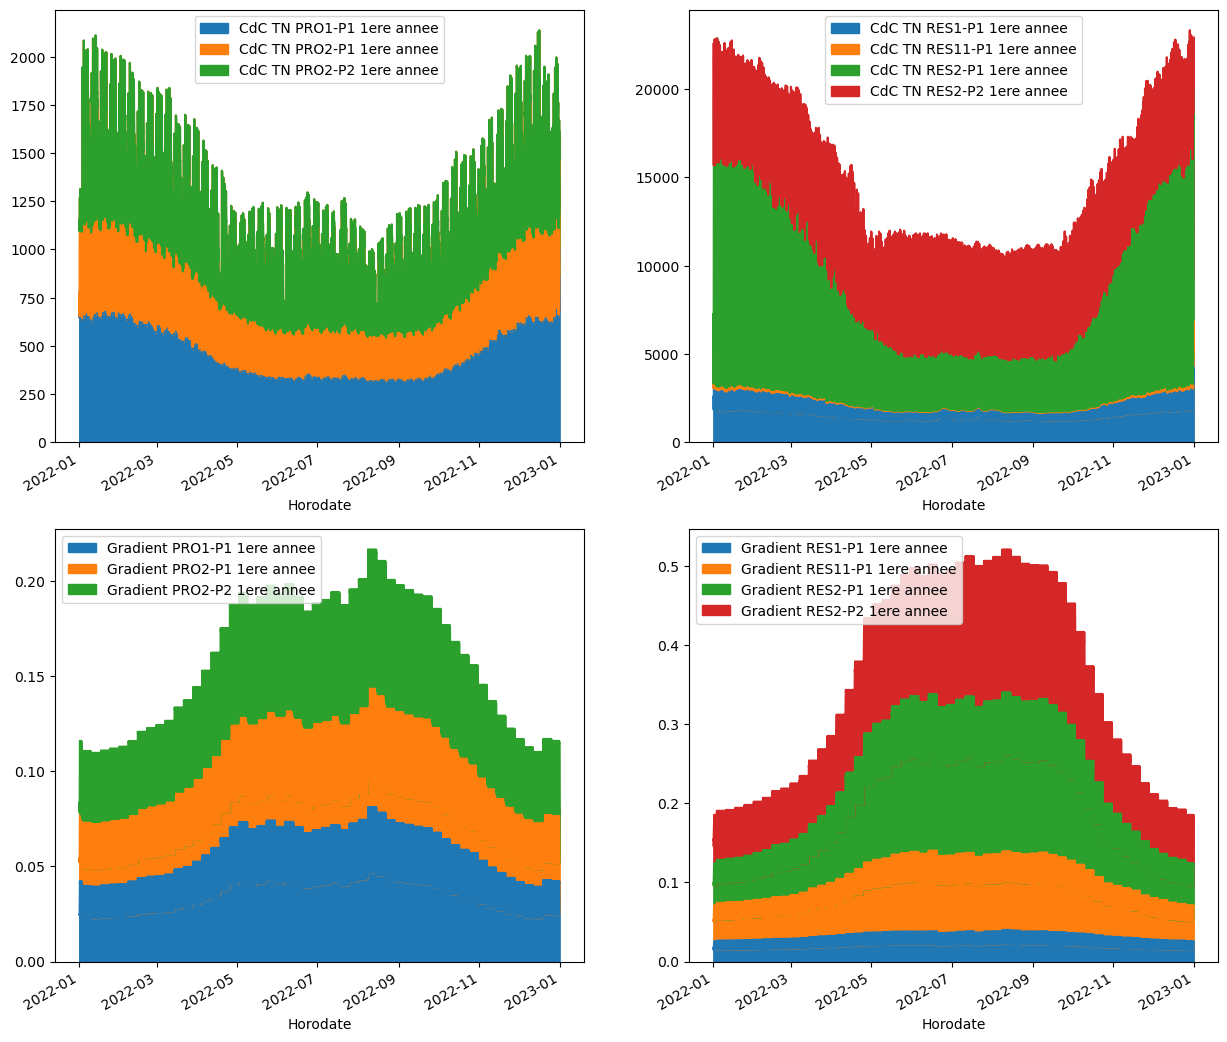

In [4]:
#Tracé données
fig,axs=plt.subplots(2,2,figsize=(15,14))
CoeffsCRE.plot.area(y=['CdC TN PRO1-P1 1ere annee','CdC TN PRO2-P1 1ere annee','CdC TN PRO2-P2 1ere annee'],ax=axs[0,0])
CoeffsCRE.plot.area(y=['CdC TN RES1-P1 1ere annee','CdC TN RES11-P1 1ere annee','CdC TN RES2-P1 1ere annee',
'CdC TN RES2-P2 1ere annee'],ax=axs[0,1])
CoeffsCRE.plot.area(y=['Gradient PRO1-P1 1ere annee','Gradient PRO2-P1 1ere annee','Gradient PRO2-P2 1ere annee'],ax=axs[1,0])
CoeffsCRE.plot.area(y=['Gradient RES1-P1 1ere annee','Gradient RES11-P1 1ere annee','Gradient RES2-P1 1ere annee',
'Gradient RES2-P2 1ere annee'],ax=axs[1,1])
plt.show()

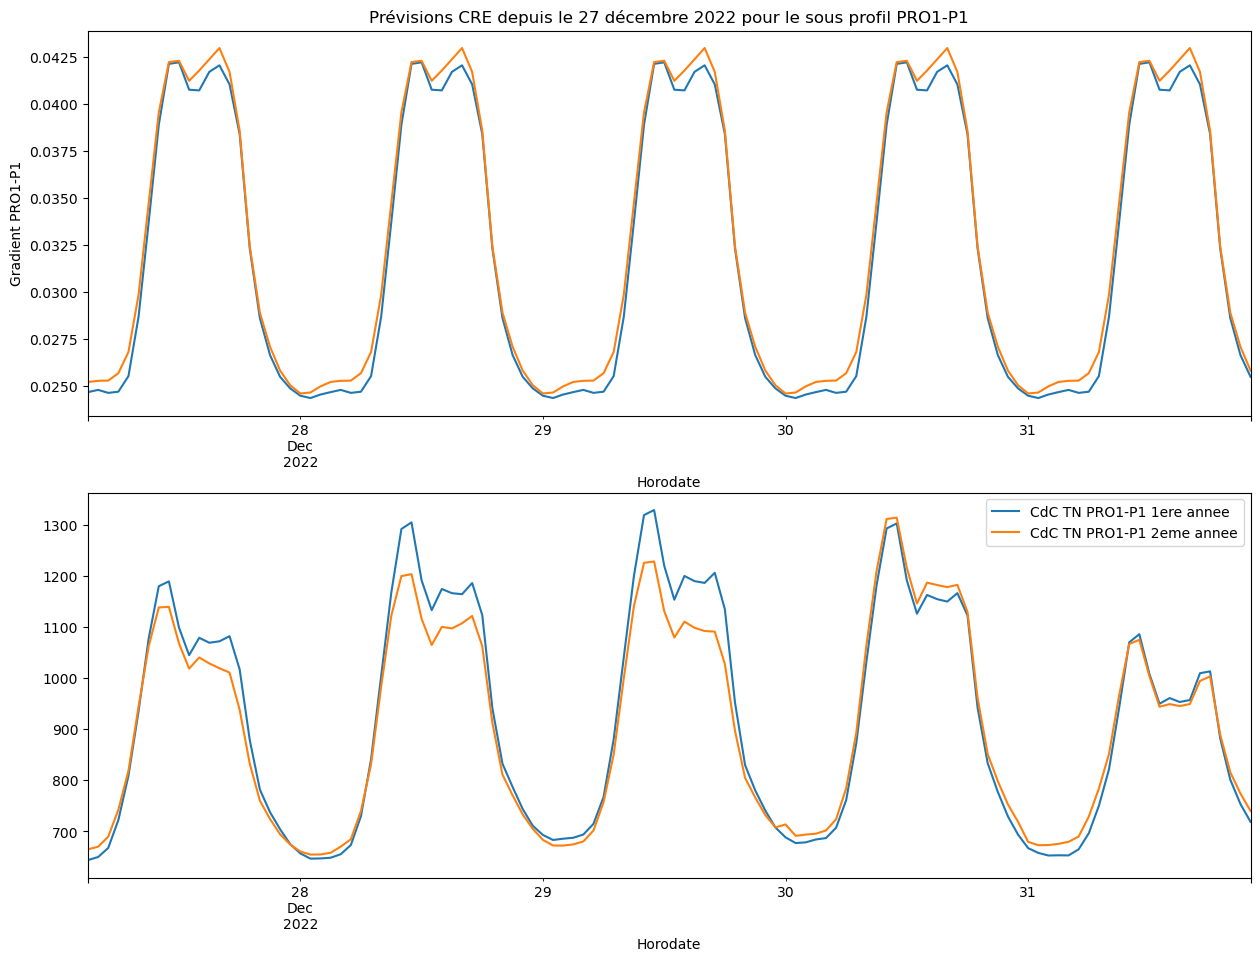

In [5]:
fig,axs=plt.subplots(2,1,figsize=(15,11))
CoeffsCRE['Gradient PRO1-P1 1ere annee'].loc[(CoeffsCRE.index > pd.to_datetime('2022-12-27T01:00:00.000Z')) & 
(CoeffsCRE.index < pd.to_datetime('2022-12-31T22:00:00.000Z'))].plot(ax=axs[0], 
title='Prévisions CRE depuis le 27 décembre 2022 pour le sous profil PRO1-P1', ylabel="Gradient PRO1-P1")
CoeffsCRE['Gradient PRO1-P1 2eme annee'].loc[(CoeffsCRE.index > pd.to_datetime('2022-12-27T01:00:00.000Z')) & 
(CoeffsCRE.index < pd.to_datetime('2022-12-31T22:00:00.000Z'))].plot(ax=axs[0])
CoeffsCRE['CdC TN PRO1-P1 1ere annee'].loc[(CoeffsCRE.index > pd.to_datetime('2022-12-27T01:00:00.000Z')) & 
(CoeffsCRE.index < pd.to_datetime('2022-12-31T22:00:00.000Z'))].plot(ax=axs[1])
CoeffsCRE['CdC TN PRO1-P1 2eme annee'].loc[(CoeffsCRE.index > pd.to_datetime('2022-12-27T01:00:00.000Z')) & 
(CoeffsCRE.index < pd.to_datetime('2022-12-31T22:00:00.000Z'))].plot(ax=axs[1])
plt.legend()
plt.show()

<ins> Comment ces données sont-elles calculées ? </ins>

Partant des historiques de sous-profils dynamiques publiés sur le site d’Enedis, le modèle de la CRE procède en trois étapes :  
    - Etape 1 : calcul des gradients de température  
    - Etape 2 : retraitement des données historiques pour les ramener à température normale et estimation des paramètres du profil  
    - Etape 3 : calibration de modèles stochastiques permettant de générer des scénarios d’écart entre consommation réalisée à température normale et profil à température normale.  

- <ins> Gradient de température : </ins>

Sur une plage de température majorée par une température seuil (15°C), RTE a remarqué une relation de proportionnalité entre la variation de la température et celle de la consommation. Le coefficient exprimant cette relation est appelé "gradient de température". Comme il est indiqué en annexe de la section F des règles MA-RE, il traduit ainsi la variation de consommation liée à une variation de 1°C de température. Il faut également prendre en compte "l'inertie" des variations de consommation sur les variations de température (principalement due à l'inertie thermique des bâtiments). Cet effet est modélisé par un décalage et une atténuation de l'amplitude des variations de température appelés par RTE "lissage des températures".

Le calcul du gradient pour chaque demi-heure se base sur la méthode "par delta" utilisée par RTE et détaillée dans les règles du mécanisme de capacité. Il consiste à effectuer une régression linéaire sur une consommation en fonction d'une température lissée seuillée qui ne prennent pas en compte certains points particuliers (jours fériés, vacances scolaires,...).

- <ins> Coefficients de consommation des années précédentes à température normale hebdomadaires et maj du gradient : </ins>

Le calcul des coefficients de consommation à température normale hebdomadaires se base sur les coefficients dynamiques fournis par ENEDIS. L'idée est d'effectuer la moyenne des valeurs historiques auxquelles on a retranché la consommation correspondant à la différence entre la température "réalisée" (= température mesurée par ENEDIS) et la température normale seuillée. Un nouveau gradient est ensuite déterminé pour chaque semaine et chaque demi-heure en calculant le produit entre le gradient précédent et le coefficient hebdomadaire tout juste calculé.

- <ins> Courbe de charge prévisionnelle et écarts </ins>

La courbe de charge historique à température normale va maintenant être normalisée pour avoir une moyenne égale à 1 puis moyennée pour avoir un profil hebdomadaire, journalier et demi-horaire. On obtient alors les coefficients de ce profil en le multipliant aux coefficients hebdomadaires calculés précédemment. Grâce aux différents paramètres calculés, la consommation (ou courbe de charge) prévisionnelle d'abord à température normale puis à température réalisée peut-être déterminée.  

La CRE propose ensuite d'évaluer l'écart entre la courbe de charge prévisionnelle et celle historique à température normale. L'étude de cet écart appelé "résidu" permet de générer des scénarios de courbes de charge pour chaque sous-profil de consommation. La CRE propose également un requalibrage de la courbe de charge en prenant en compte la relève mensuelle des données de consommations grâce aux compteurs Linky. Cela permet d'intégrer au calcul le risque porté par les fournisseurs à chaque relève.

Les courbes de charge sous leur forme actuelle ne nous intéressent pas car elles sont restreintes au périmètre utilisé par la CRE. Il nous faut retrouver les coefficients dynamiques $C_{s,j,h,a}^{sous profil}$ qui ont permis de les calculer. Or, nous savons que :
$$ P_{s,j,h,a}^{sous profil}= \frac{2 \times CAR^{sous profil}}{\sum C_{s,j,h,a}^{sous profil}}.C_{s,j,h,a}^{sous profil} $$

Avec:
- $P_{s,j,h,a}^{sous profil}$ la puissance soutirée en MW par année a, semaine s,jour j et heure h pour chaque sous-profil
- $C_{s,j,h,a}^{sous profil}$ le coefficient du sous profil par année a, semaine s,jour j et heure h (non nul)
- $CAR^{sous profil}$ la consommation annuelle de référence en MWh par sous-profil

Résoudre cette équation revient à chercher les zéros de la fonction f telle que :
$$ f_{sous profil}(C)= P_{s,j,h,a}-\frac{2 \times CAR}{\sum C_{s,j,h,a}}.C_{s,j,h,a}$$

In [6]:
#Récupération des données pour le calcul de la CAR
BDD_CRE=pd.read_excel("2eme semestre 2022.xlsx",sheet_name="BDD",skiprows=4)

In [7]:
# Calcul des CAR de chaque sous profil données BDD (2021)
CAR=dict({'PRO1-P1' : 0, 'PRO2-P1':0,'PRO2-P2':0, 'RES1-P1':0,'RES11-P1':0,'RES2-P1':0,'RES2-P2':0})
CAR['PRO1-P1']=sum(BDD_CRE['Consommation totale en kWh'][BDD_CRE['Type']=='PRO'][BDD_CRE['Option']=='BASE'])/1000
CAR['PRO2-P1']=sum(BDD_CRE['Consommation totale en kWh'][BDD_CRE['Type']=='PRO'][BDD_CRE['Option']=='HPHC'])/1000
CAR['PRO2-P2']=CAR['PRO2-P1']/1000
CAR['RES1-P1']=sum(BDD_CRE['Consommation totale en kWh'][BDD_CRE['Type']=='RES'][BDD_CRE['Option']=='BASE'])/1000
CAR['RES11-P1']=CAR['RES1-P1']/1000
CAR['RES2-P1']=sum(BDD_CRE['Consommation totale en kWh'][BDD_CRE['Type']=='RES'][BDD_CRE['Option']=='HPHC'])/1000
CAR['RES2-P2']=CAR['RES2-P1']/1000

In [8]:
#Calcul CAR comme la somme des consommations de 2022 par sous profil
CARs=dict({'PRO1-P1' : 0, 'PRO2-P1':0,'PRO2-P2':0, 'RES1-P1':0,'RES11-P1':0,'RES2-P1':0,'RES2-P2':0})
CARs['PRO1-P1']=sum(CoeffsCRE['CdC TN PRO1-P1 1ere annee'])
CARs['PRO2-P1']=sum(CoeffsCRE['CdC TN PRO2-P1 1ere annee'])
CARs['PRO2-P2']=sum(CoeffsCRE['CdC TN PRO2-P2 1ere annee'])
CARs['RES1-P1']=sum(CoeffsCRE['CdC TN RES1-P1 1ere annee'])
CARs['RES11-P1']=sum(CoeffsCRE['CdC TN RES11-P1 1ere annee'])
CARs['RES2-P1']=sum(CoeffsCRE['CdC TN RES2-P1 1ere annee'])
CARs['RES2-P2']=sum(CoeffsCRE['CdC TN RES2-P2 1ere annee'])
CARs=np.array(list(CARs.values()))

In [9]:
#tentative de résolution du système sous forme Ax=b avec pivot de Gauss
# P2=CoeffsCRE.loc[:pd.to_datetime('2022-03-01T01:00:00.000Z'),'CdC TN PRO1-P1 1ere annee'].to_numpy()
# A2=np.ones((len(P2),len(P2)))
# for i in range(len(P2)):
#     A2[i,:]*=P2[i]
#     A2[i,i]+=-2*CARs[0]
# B2=np.ones((len(P2),1))*1e-8
# C2=np.linalg.solve(A2,B2)
# C2

Fonction $f_{sous profil}$

In [34]:
def f(C,sous_profil):
    if sous_profil=='PRO1-P1':
        P=CoeffsCRE['CdC TN PRO1-P1 1ere annee'].to_numpy()
        return P-(CARs[0]*2/np.sum(C))*C
    elif sous_profil=='PRO2-P1':
        P=CoeffsCRE['CdC TN PRO2-P1 1ere annee'].to_numpy()
        return P-(CARs[1]*2/np.sum(C))*C
    elif sous_profil=='PRO2-P2':
        P=CoeffsCRE['CdC TN PRO2-P2 1ere annee'].to_numpy()
        return P-(CARs[2]*2/np.sum(C))*C
    elif sous_profil=='RES1-P1':
        P=CoeffsCRE['CdC TN RES1-P1 1ere annee'].to_numpy()
        return P-(CARs[3]*2/np.sum(C))*C
    elif sous_profil=='RES11-P1':
        P=CoeffsCRE['CdC TN RES11-P1 1ere annee'].to_numpy()
        return P-(CARs[4]*2/np.sum(C))*C
    elif sous_profil=='RES2-P1':
        P=CoeffsCRE['CdC TN RES2-P1 1ere annee'].to_numpy()
        return P-(CARs[5]*2/np.sum(C))*C 
    elif sous_profil=='RES2-P2':
        P=CoeffsCRE['CdC TN RES2-P2 1ere annee'].to_numpy()
        return P-(CARs[6]*2/np.sum(C))*C

Calcul de la matrice jacobienne en utilisant sympy

In [20]:
def SympyFunc(x,sous_profil):
    P1=CoeffsCRE.loc[:pd.to_datetime('2022-01-01T03:00:00.000Z'),'CdC TN PRO1-P1 1ere annee'].to_numpy()
    P=sp.SparseMatrix(P1)
    if sous_profil=='PRO1-P1':
        k=2*CARs[0]
    return P-(k/np.sum(x))*x

def SympyJacobian(x,sous_profil):
    return SympyFunc(x,sous_profil).jacobian(x)

def jacobian(C,sous_profil):
    lx,ls=[],[]
    k=len(C)
    for i in range(k):
        lx.append(sp.Symbol(f"x{i}"))
        x=sp.SparseMatrix(np.array(lx))
    S=SympyJacobian(x,sous_profil)
    for i in range(k):
        ls.append((lx[i],C[0,i]))
    J=S.subs(ls)
    return np.array(J)

In [12]:
lx=[]
for i in range(5):
    lx.append(sp.Symbol(f"x{i}"))
    x=sp.SparseMatrix(np.array(lx))
SympyJacobian(x,'PRO1-P1')

Matrix([
[11364436.0*x0/(x0 + x1 + x2 + x3 + x4)**2 - 11364436.0/(x0 + x1 + x2 + x3 + x4),                                       11364436.0*x0/(x0 + x1 + x2 + x3 + x4)**2,                                       11364436.0*x0/(x0 + x1 + x2 + x3 + x4)**2,                                       11364436.0*x0/(x0 + x1 + x2 + x3 + x4)**2,                                       11364436.0*x0/(x0 + x1 + x2 + x3 + x4)**2],
[                                      11364436.0*x1/(x0 + x1 + x2 + x3 + x4)**2, 11364436.0*x1/(x0 + x1 + x2 + x3 + x4)**2 - 11364436.0/(x0 + x1 + x2 + x3 + x4),                                       11364436.0*x1/(x0 + x1 + x2 + x3 + x4)**2,                                       11364436.0*x1/(x0 + x1 + x2 + x3 + x4)**2,                                       11364436.0*x1/(x0 + x1 + x2 + x3 + x4)**2],
[                                      11364436.0*x2/(x0 + x1 + x2 + x3 + x4)**2,                                       11364436.0*x2/(x0 + x1 + x2 + x3 + x4)**2, 11364436.0*x2/

Calcul de la matrice jacobienne via numpy en utilisant le résultat de sympy

In [13]:
def Jac(C,sous_profil):
    S=np.sum(C)
    J=np.zeros((len(C),len(C)))
    if sous_profil=='PRO1-P1':
        k=CARs[0]*2
    elif sous_profil=='PRO2-P1':
        k=CARs[1]*2
    elif sous_profil=='PRO2-P2':
        k=CARs[2]*2
    elif sous_profil=='RES1-P1':
        k=CARs[3]*2
    elif sous_profil=='RES11-P1':
        k=CARs[4]*2
    elif sous_profil=='RES2-P1':
        k=CARs[5]*2 
    elif sous_profil=='RES2-P2':
        k=CARs[6]*2
    for i in range(len(C)):
        J[i,:]=k*C[i]/(S**2)
    J=J-np.identity(len(C))*(k/S)
    return J

In [35]:
P=CoeffsCRE['CdC TN PRO1-P1 1ere annee'].to_numpy()
P.shape[0]

8760

Construction du vecteur C0 estimant la solution

In [36]:
C0=np.ones((1,P.shape[0]))
C0.shape[1]

8760

Test du calcul de la jacobienne sur C0 (calcul très rapide !)

In [16]:
J=Jac(C0.tolist()[0],"PRO1-P1")
J

array([[-1.29716195e+03,  1.48094754e-01,  1.48094754e-01, ...,
         1.48094754e-01,  1.48094754e-01,  1.48094754e-01],
       [ 1.48094754e-01, -1.29716195e+03,  1.48094754e-01, ...,
         1.48094754e-01,  1.48094754e-01,  1.48094754e-01],
       [ 1.48094754e-01,  1.48094754e-01, -1.29716195e+03, ...,
         1.48094754e-01,  1.48094754e-01,  1.48094754e-01],
       ...,
       [ 1.48094754e-01,  1.48094754e-01,  1.48094754e-01, ...,
        -1.29716195e+03,  1.48094754e-01,  1.48094754e-01],
       [ 1.48094754e-01,  1.48094754e-01,  1.48094754e-01, ...,
         1.48094754e-01, -1.29716195e+03,  1.48094754e-01],
       [ 1.48094754e-01,  1.48094754e-01,  1.48094754e-01, ...,
         1.48094754e-01,  1.48094754e-01, -1.29716195e+03]])

Affichage de f calculée sur un intervalle de la taille de C0

In [17]:
x=np.linspace(-10,8760,C0.shape[1])
fig=px.line(x=x,y=f(x,'PRO1-P1'))
fig.show()

Calcul des racines avec la méthode "hybr" qui est une modification de la méthode hybride de Powell implémentée dans Minpack (profil PRO1 P1)

In [18]:
# C=optimize.root(f,C0,'PRO1-P1',jac=Jac,method='hybr')
# C=C.x

Calcul avec fsolve qui utilise plusieurs méthodes hybrides semblables à root  
Profil PRO1 P1  
Tolérance fixée à $10^-8$

In [223]:
C=optimize.fsolve(f,C0,'PRO1-P1',fprime=Jac,full_output=0, col_deriv=0, xtol=1e-8, factor=100)
C

c:\Users\AlexandreCastanie\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.



array([15.23702052, 15.1361636 , 15.08729312, ..., 16.33566295,
       15.928504  , 15.52643782])

In [ ]:
fig=px.line(x=x,y=C,title="Coeffs dynamiques PRO1 P1")
fig.show()

Création d'un excel contenant les résultats :

In [61]:
workbook = xlsxwriter.Workbook('ResultatsCalculPRO1P1.xlsx')

In [259]:
worksheet = workbook.add_worksheet('1ere annee et tolerance=1e-8')

row = 0
col=0
# iterating through content list
for date,coeff in [[str(CoeffsCRE.index[i]),C[i]] for i in range(len(CoeffsCRE.index))] :
 
    # write operation perform
    worksheet.write(row, col, date)
    worksheet.write(row, col+1, coeff)
    # incrementing the value of row by one
    # with each iterations.
    row += 1

workbook.close()

Calcul avec fsolve  
Tolérance fixée à $10^-3$

In [52]:
C2=optimize.fsolve(f,C0,'PRO1-P1',full_output=0, col_deriv=0, xtol=1e-3, factor=100)
C2

c:\Users\AlexandreCastanie\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



array([189.05142209, 187.79327982, 187.1913628 , ..., 202.73089662,
       197.6599714 , 192.66511674])

In [53]:
x2=np.linspace(0,C0.shape[1],C0.shape[1])
fig=px.line(x=x2,y=C2,title="Coeffs dynamiques PRO1 P1")
fig.show()

In [65]:
worksheet = workbook.add_worksheet('1ere annee et tolerance111=1e-3')

row = 0
col=0
# iterating through content list
for date,coeff in [[str(CoeffsCRE.index[i]),C2[i]] for i in range(len(CoeffsCRE.index))] :
 
    # write operation perform
    worksheet.write(row, col, date)
    worksheet.write(row, col+1, coeff)
    # incrementing the value of row by one
    # with each iterations.
    row += 1

workbook.close()

Fonction pour la deuxième année de lissage :

In [43]:
def f2(C,sous_profil):
    if sous_profil=='PRO1-P1':
        P=CoeffsCRE['CdC TN PRO1-P1 2eme annee'].to_numpy()
        return P-(CARs[0]*2/np.sum(C))*C
    elif sous_profil=='PRO2-P1':
        P=CoeffsCRE['CdC TN PRO2-P1 2eme annee'].to_numpy()
        return P-(CARs[1]*2/np.sum(C))*C
    elif sous_profil=='PRO2-P2':
        P=CoeffsCRE['CdC TN PRO2-P2 2eme annee'].to_numpy()
        return P-(CARs[2]*2/np.sum(C))*C
    elif sous_profil=='RES1-P1':
        P=CoeffsCRE['CdC TN RES1-P1 2eme annee'].to_numpy()
        return P-(CARs[3]*2/np.sum(C))*C
    elif sous_profil=='RES11-P1':
        P=CoeffsCRE['CdC TN RES11-P1 2eme annee'].to_numpy()
        return P-(CARs[4]*2/np.sum(C))*C
    elif sous_profil=='RES2-P1':
        P=CoeffsCRE['CdC TN RES2-P1 2eme annee'].to_numpy()
        return P-(CARs[5]*2/np.sum(C))*C 
    elif sous_profil=='RES2-P2':
        P=CoeffsCRE['CdC TN RES2-P2 2eme annee'].to_numpy()
        return P-(CARs[6]*2/np.sum(C))*C

In [44]:
C3=optimize.fsolve(f2,C0,'PRO1-P1',fprime=Jac,full_output=0, col_deriv=0, xtol=1e-8, factor=100)
C3

c:\Users\AlexandreCastanie\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.



array([18.709197  , 18.66560519, 18.5794353 , ..., 20.12981745,
       19.64727188, 19.14139796])

In [45]:
fig=px.line(x=CoeffsCRE.index,y=C3,title="Coeffs dynamiques PRO1 P1")
fig.show()

In [51]:
worksheet = workbook.add_worksheet('2eme annee et tol=1e-8')

row = 0
col=0
# iterating through content list
for date,coeff in [[str(CoeffsCRE.index[i]),C3[i]] for i in range(len(CoeffsCRE.index))] :
 
    # write operation perform
    worksheet.write(row, col, date)
    worksheet.write(row, col+1, coeff)
    # incrementing the value of row by one
    # with each iterations.
    row += 1

workbook.close()